In [69]:
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [70]:


def read_data(path_list, im_size=(224, 224)):

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}
    print(tag2idx)

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                # im = quantize_image(im)
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)

    return X, y, tag2idx

In [71]:
IM_SIZE = (256, 256)
PATH_LIST = ["D:\data\Grape___Black_rot"]
X, y, tag2idx = read_data(PATH_LIST, IM_SIZE)

{'Grape___Black_rot': 0}


100%|██████████| 384/384 [00:00<00:00, 987.55it/s]


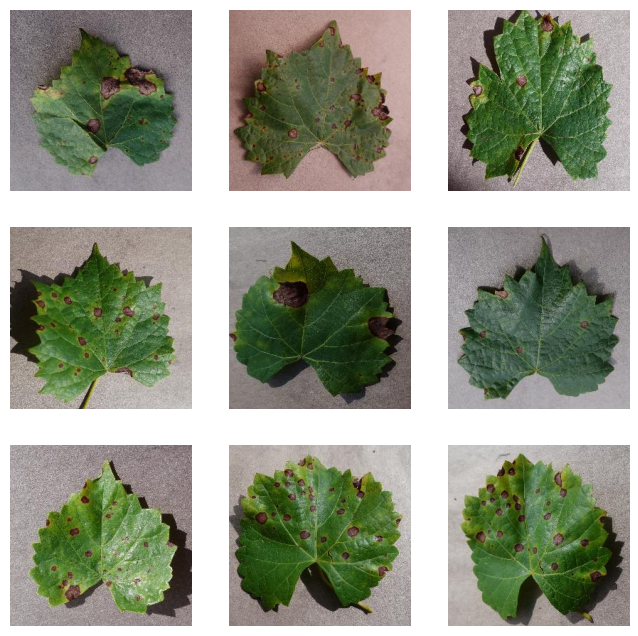

In [72]:
def plot_sample(X):
    # Plotting 9 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(8, 8))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])

plot_sample(X)

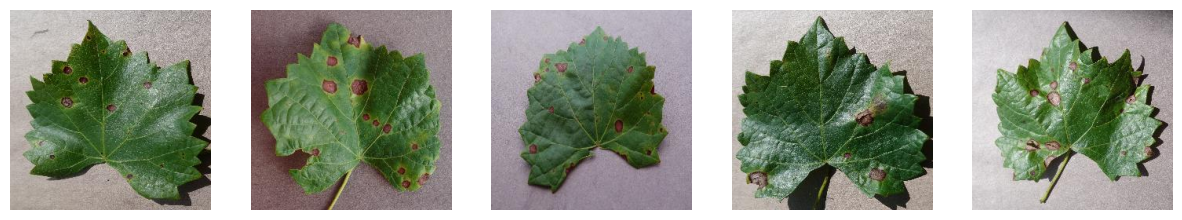

In [73]:
def plot_sample(images, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

plot_sample(X)

In [74]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.15
RANDOM_STATE = 2021

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT, shuffle=True, stratify=y, random_state=RANDOM_STATE
)

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.0, clip_value_max=1.0)



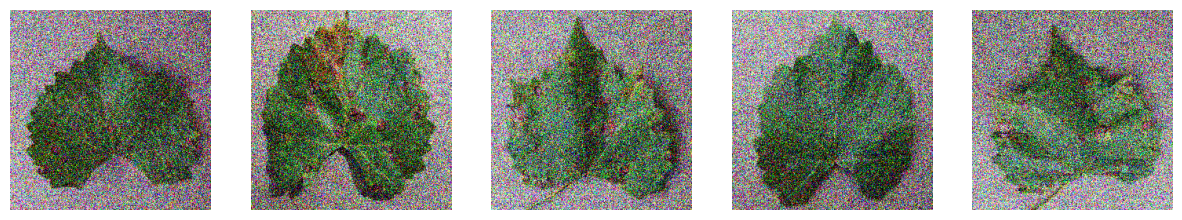

In [75]:
plot_sample(x_train_noisy)

In [79]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = model.Sequential([
            layers.Input(shape=(256, 256, 3)),
            layers.Conv2D(128, (3, 3), activation="relu", padding="same", strides=2),
            layers.Conv2D(64, (3, 3), activation="relu", padding="same", strides=2),
            layers.Conv2D(32, (3, 3), activation="relu", padding="same", strides=2)
        ])
        
        self.decoder = model.Sequential([
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation="relu", padding="same"),
            layers.Conv2D(3, kernel_size=(3, 3), activation="sigmoid", padding="same")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

NameError: name 'model' is not defined

In [61]:
autoencoder = Denoise()

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error'
)

NUM_EPOCHS = 100

In [65]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.8, patience=NUM_EPOCHS // 20, verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=NUM_EPOCHS // 15,
    verbose=1,
    restore_best_weights=True,
)
model_checkpoint = ModelCheckpoint(
    'utoencoder_best.keras', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

In [66]:
BATCH_SIZE = 8

In [67]:
history = autoencoder.fit(
    x_train_noisy, x_train,  # Noisy images as inputs, clean images as targets
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test_noisy, x_test),
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.0350
Epoch 1: val_loss improved from inf to 0.00897, saving model to utoencoder_best.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - loss: 0.0348 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 2/100
36/41 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.0082

KeyboardInterrupt: 